# Uncertainties in DNNs

Load dependencies:

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import warnings
from tensorflow_probability import layers, distributions

Simulate function:
$$ Y = WX + \boldsymbol{\epsilon} $$ 
with 
$$ \epsilon_i \sim N(0, \sigma) $$

In [3]:
def simulate(E=2, N=50, S=0.1):
    W = np.random.normal(0.0, 1.0, [E, 1])
    X1 = np.arange(1, N+1, 1)/100
    X1 = (X1 - np.mean(X1))/np.std(X1)
    X2 = np.random.uniform(-5, 5, N)
    Y = 3+np.reshape(-np.abs(np.log( X1+np.abs(np.min(X1))+0.1 ) )*0.45+ X2*np.sin(X2)*0.1 + np.random.normal(0.0, (np.cos(X2)+1.8)*S, N), [-1,1])
    X2 = (X2 - np.mean(X2))/np.std(X2)
    X = np.concatenate(( np.reshape(X1, [-1,1]), np.reshape(X2, [-1,1]) ),1)
    #Y = np.matmul(X, W) + np.random.normal(0.0, S, [N, 1])
    #Y = (Y - np.mean(Y))#/np.std(Y)
    return X, Y, W

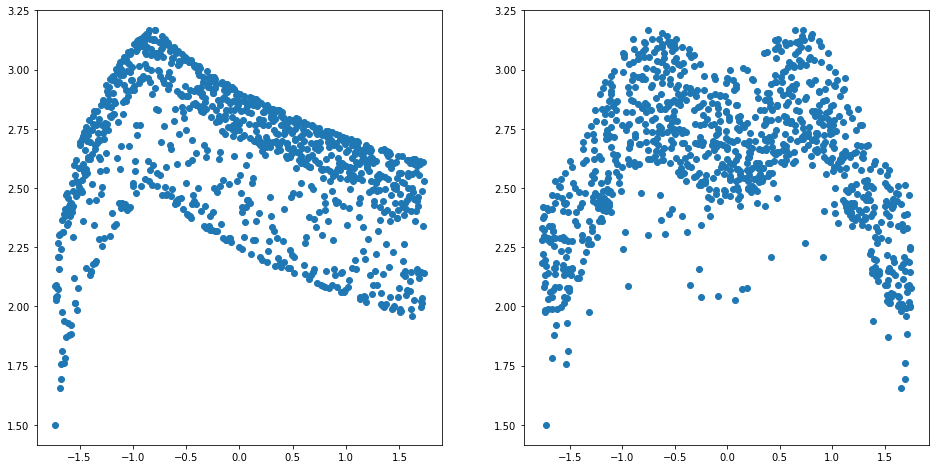

In [4]:
np.random.seed(8)
X, Y, W = simulate(N = 1000, S = 0.001)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(X[:,0], Y)
plt.subplot(1, 2, 2)
plt.scatter(X[:,1], Y)


## Linear regression model

In [5]:
def linear_model(X, Y, W,  epochs=100, batch_size=25):

    # no hidden layers!
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[X.shape[1]]),
        tf.keras.layers.Dense(units=1, activation=None)
    ])
    model.summary()
    
    # loss function: Normal log-ll with constant std
    ll = lambda true, obs: -tfp.distributions.Normal(obs, 1.0 ).log_prob(true)
    model.compile(loss = ll, optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.01))
    model.fit(X, Y, epochs = epochs, batch_size = batch_size, verbose = 0)
    return model, model.trainable_variables, _, model.predict(X)

# in R lm(Y~X)
def linear_model_std(X, Y, W,  epochs=100, batch_size=25):

    # no hidden layers!
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[X.shape[1]]),
        tf.keras.layers.Dense(units=1, activation=None)
    ])
    model.summary()
    model.add_weight(name = "stddev", 
                    shape=(), 
                    initializer = tf.keras.initializers.Constant(value=1.0),
                    trainable=True)
    
    # loss function: Normal log-ll with constant std
    ll = lambda true, obs: -tfp.distributions.Normal(obs, tf.clip_by_value(model.trainable_variables[-1], 0,10) ).log_prob(true)
    model.compile(loss = ll, optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.01))
    model.fit(X, Y, epochs = epochs, batch_size = batch_size, verbose = 0)
    return model, model.trainable_variables, tf.clip_by_value(model.trainable_variables[-1],0,10), model.predict(X)

def DNN_model(X, Y, W,  epochs=100, batch_size=25, hidden = 50):

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[X.shape[1]]),
        tf.keras.layers.Dense(units=hidden, activation="relu"),
        tf.keras.layers.Dense(units=hidden, activation="relu"),
        tf.keras.layers.Dense(units=1, activation=None)
    ])
    model.summary()
    
    # loss function: Normal log-ll with constant std
    ll = lambda true, obs: -tfp.distributions.Normal(obs, 1.0 ).log_prob(true)
    model.compile(loss = ll, optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.01))
    model.fit(X, Y, epochs = epochs, batch_size = batch_size, verbose = 0)
    return model, model.trainable_variables, _, model.predict(X)

def DNN_model_std(X, Y, W,  epochs=100, batch_size=25, hidden=50):

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[X.shape[1]]),
        tf.keras.layers.Dense(units=hidden, activation="relu"),
        tf.keras.layers.Dense(units=hidden, activation="relu"),
        tf.keras.layers.Dense(units=1)
    ])
    model.summary()
    model.add_weight(name = "stddev", 
                    shape=(), 
                    initializer = tf.keras.initializers.Constant(value=1.0),
                    trainable=True)
    
    # loss function: Normal log-ll with constant std
    ll = lambda true, obs: -tfp.distributions.Normal(obs, tf.clip_by_value(model.trainable_variables[-1],0, 10) ).log_prob(true)
    model.compile(loss = ll, optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.01))
    model.fit(X, Y, epochs = epochs, batch_size = batch_size, verbose = 0)
    return model, model.trainable_variables, tf.clip_by_value(model.trainable_variables[-1],0,10), model.predict(X)

In [6]:
with tf.device("CPU"):
    results = linear_model(X, Y, W)
    results_std = linear_model_std(X, Y, W)
    results_dnn = DNN_model(X, Y, W, hidden=200)
    results_dnn_std = DNN_model_std(X, Y, W)

2022-02-04 14:41:36.376125: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-04 14:41:36.376239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-04 14:41:36.423193: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)

LM without std:

In [301]:
print(f'True weights: {W.squeeze()}')
print(f'Estimated weights: {*[w.squeeze().tolist() for w in results[0].get_weights()], }' )

True weights: [0.09120472 1.09128273]
Estimated weights: ([-0.0769595056772232, 0.004529696889221668], 2.618278741836548)


LM with std:

In [302]:
print(f'True weights: {W.squeeze()}')
print(f'Estimated weights: {*[w.squeeze().tolist() for w in results_std[0].get_weights()], }' )
print(f'LM: True std: 0.3', f'Estimated std: {results_std[2]}')
print(f'DNN: True std: 0.3', f'Estimated std: {results_dnn_std[2]}')

True weights: [0.09120472 1.09128273]
Estimated weights: ([-0.07365191727876663, 0.005793728865683079], 2.613849401473999, 0.29103949666023254)
LM: True std: 0.3 Estimated std: 0.29103949666023254
DNN: True std: 0.3 Estimated std: 0.017003120854496956


<Figure size 432x288 with 0 Axes>

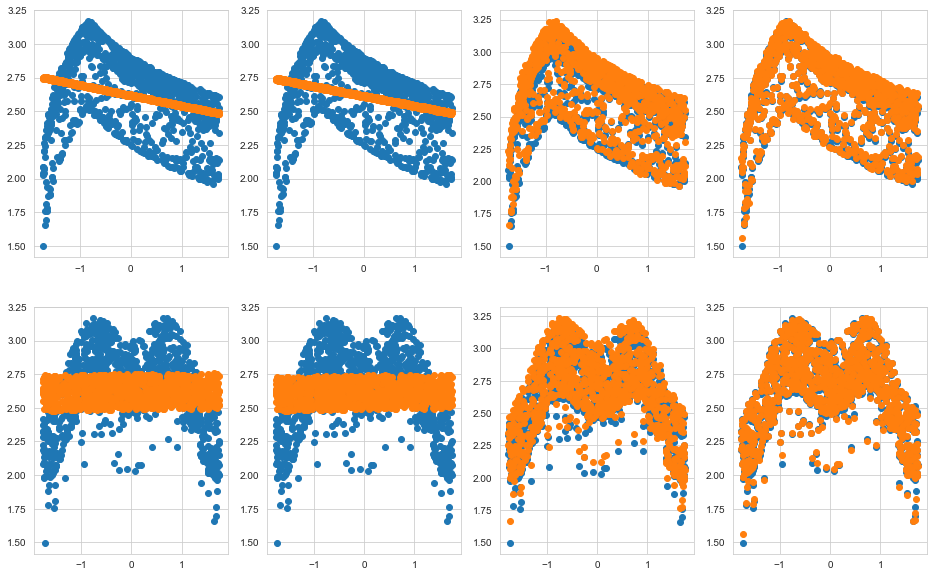

In [309]:
fig = plt.figure()
plt.figure(figsize=(16, 10))
plt.subplot(2, 4, 1)
plt.scatter(X[:,0], Y)
plt.scatter(X[:,0], results[3])
plt.subplot(2, 4, 2)
plt.scatter(X[:,0], Y)
plt.scatter(X[:,0], results_std[3])
plt.subplot(2, 4, 3)
plt.scatter(X[:,0], Y)
plt.scatter(X[:,0], results_dnn[3])
plt.subplot(2, 4, 4)
plt.scatter(X[:,0], Y)
plt.scatter(X[:,0], results_dnn_std[3])

plt.subplot(2, 4, 5)
plt.scatter(X[:,1], Y)
plt.scatter(X[:,1], results[3])
plt.subplot(2, 4, 6)
plt.scatter(X[:,1], Y)
plt.scatter(X[:,1], results_std[3])
plt.subplot(2, 4, 7)
plt.scatter(X[:,1], Y)
plt.scatter(X[:,1], results_dnn[3])
plt.subplot(2, 4, 8)
plt.scatter(X[:,1], Y)
plt.scatter(X[:,1], results_dnn_std[3])


But no predictive uncertainties!!!

## Simple example of variational inference

<AxesSubplot:ylabel='Density'>

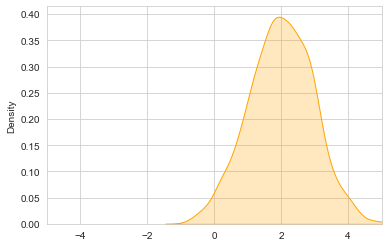

In [97]:
X = np.random.normal(2, 1.0, size=1000)
XT = tf.constant(X, dtype="float32")
plt.xlim(-5, 5)
sn.distplot(X, color="orange", hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 1})

Mean: 1.9366737604141235
Sd: 0.9469203948974609


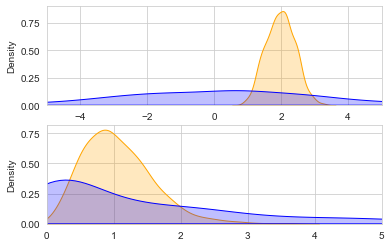

In [98]:
with tf.device("CPU"):
    Vars = tf.Variable([0.0,0.0, 1.0, 1.0], dtype=tf.float32)
    prior_mu = tfp.distributions.Normal(0.0, 10.0)
    prior_sd = tfp.distributions.Normal(0.0, 10.0)

    opt = tf.keras.optimizers.Adamax(learning_rate=0.1)

    for _ in range(500):
        with tf.GradientTape() as tape:
            posterior_mu = tfp.distributions.Normal(Vars[0], tf.math.softplus(Vars[2]))
            posterior_sd = tfp.distributions.Normal(Vars[1], tf.math.softplus(Vars[3]))
            mu = tf.reduce_mean(posterior_mu.sample(20))
            sd = tf.reduce_mean(posterior_sd.sample(20))
            ll= -tf.reduce_mean(tfp.distributions.Normal(mu, tf.math.softplus(sd)).log_prob(XT))
            ll += tfp.distributions.kl_divergence(posterior_mu, prior)/XT.shape[0]
            ll += tfp.distributions.kl_divergence(posterior_sd, prior)/XT.shape[0]
            #tf.print(ll)
        grads = tape.gradient(ll, Vars)
        _ = opt.apply_gradients(zip([grads], [Vars]))
        
    plt.subplot(2, 1, 1)
    plt.xlim(-5, 5)
    sn.distplot(posterior_mu.sample(500), color="orange", hist=False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 1})
    sn.distplot(prior.sample(500), color="blue", hist=False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 1})
    
    plt.subplot(2, 1, 2)
    plt.xlim(0, 5)
    sn.distplot(tf.math.softplus(posterior_sd.sample(500)), color="orange", hist=False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 1})
    sn.distplot(tf.math.softplus(prior.sample(500)), color="blue", hist=False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 1})
    
    print(f'Mean: {tf.reduce_mean(posterior_mu.sample(100))}')
    print(f'Sd: {tf.math.softplus(tf.reduce_mean(posterior_sd.sample(100)))}')

## Bayesian Neural Networks

Help functions:

In [7]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model
 
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n*2, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
          tfp.distributions.Normal(loc=t[0:n], scale=tf.exp(t[n:])),
          reinterpreted_batch_ndims=1)),
  ])
 
# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior_MVN(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

def posterior_diag(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.IndependentNormal.params_size(n), dtype=dtype
            ),
            tfp.layers.IndependentNormal(n),
        ]
    )
    return posterior_model

def bounds_and_coverage(preds, true):
    mean_preds = np.mean(preds, 1).reshape([-1, 1])#-true
    mean_stddev = np.std(preds, 1).reshape([-1, 1])#-true
    upper = (mean_preds + (1.96 * mean_stddev)).tolist()
    lower = (mean_preds - (1.96 * mean_stddev)).tolist()
    bounds = np.concatenate((np.asarray(upper), np.asarray(lower)), 1)
    coverage = np.mean(( true < bounds[:,[0]] )&( true > bounds[:,[1]] ))
    return mean_preds, bounds, coverage

def plot_uncertainties(preds, true, X):
    mean_preds, bounds, coverage = bounds_and_coverage(preds, true)
    plt.scatter(X, true, color="red", label="y")
    plt.scatter(X, mean_preds, color="blue", label="pred")
    plt.scatter(X, bounds[:,[0]], alpha=0.7,
        color="orange", label="upper")
    plt.scatter(X, bounds[:,[1]], alpha=0.7,
        color="orange", label="lower")
    plt.legend(loc="upper left")
    plt.text(1, -1.5, f'Coverage: {np.round(coverage, 3)}')
    return np.concatenate((mean_preds, bounds), 1), coverage

In [41]:
def BNN_model_linear(X, Y, W,  epochs=100, batch_size=25, posterior="diag"):
    if posterior == "MVN":
        posterior = posterior_MVN
    else:
        posterior = posterior_diag
    
    train_size = X.shape[0]
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[X.shape[1]]),
        tfp.layers.DenseVariational(
            units=1,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation=None,),
    ])
    model.summary()
    model.add_weight(name = "stddev", 
                    shape=(), 
                    initializer = tf.keras.initializers.Constant(value=1.0),
                    trainable=True)
    
    # loss function: Normal log-ll with constant std
    ll = lambda true, obs: -tfp.distributions.Normal(obs, tf.clip_by_value(model.trainable_variables[-1], 0, 10) ).log_prob(true)
    model.compile(loss = ll, optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.01))
    model.fit(X, Y, epochs = epochs, batch_size = batch_size, verbose = 0)
    return model, model.trainable_variables, tf.clip_by_value(model.trainable_variables[-1], 0, 10), tf.concat([model(X) for _ in range(20)], axis = 1).numpy()

def BNN_model(X, Y, W,  epochs=100, batch_size=25, hidden=50, posterior="diag"):
    if posterior == "MVN":
        posterior = posterior_MVN
    else:
        posterior = posterior_diag
    train_size = X.shape[0]
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[X.shape[1]]),
        tfp.layers.DenseVariational(
            units=hidden,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="relu",),
        tfp.layers.DenseVariational(
            units=hidden,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="relu",),
        #tfp.layers.DenseVariational(
        #    units=2,
        #    make_prior_fn=prior,
        #    make_posterior_fn=posterior,
        #    kl_weight=1 / train_size,
        #    activation=None,),
        tf.keras.layers.Dense(1, activation=None),
    ])
    model.summary()
    model.add_weight(name = "stddev", 
                    shape=(), 
                    initializer = tf.keras.initializers.Constant(value=1.0),
                    trainable=True)
    
    # loss function: Normal log-ll with constant std
    #ll = lambda true, obs: tf.reduce_mean(-obs.log_prob(true))
    ll = lambda true, obs: -tfp.distributions.Normal(obs, tf.clip_by_value(model.trainable_variables[-1], 0, 10) ).log_prob(true)
    model.compile(loss = ll, optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001))
    model.fit(X, Y, epochs = epochs, batch_size = batch_size, verbose = 1)
    pred = tf.concat([model(X) for _ in range(20)], axis = 1).numpy()
    #pred=tf.transpose(tf.squeeze(model(X).sample(100))).numpy()
    return model, model.trainable_variables, tf.clip_by_value(model.trainable_variables[-1], 0 , 10), pred

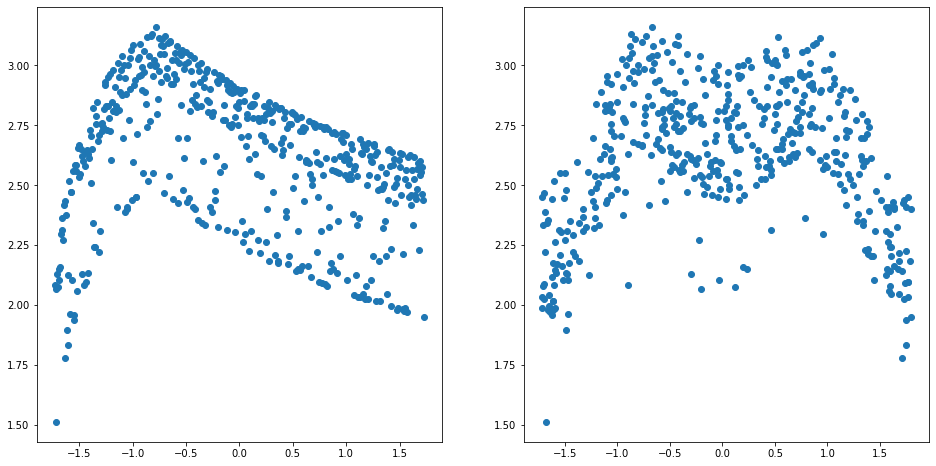

In [38]:
np.random.seed(8)
X, Y, W = simulate(N = 500, S = 0.001)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(X[:,0], Y)
plt.subplot(1, 2, 2)
plt.scatter(X[:,1], Y)

In [42]:
with tf.device("CPU"):
    results = BNN_model_linear(X, Y, W, posterior="diag")
    results_dnn = BNN_model(X, Y, W, epochs=150, hidden=40, batch_size=50,posterior="Diag")


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_44 (Dense  (None, 1)                6         
 Variational)                                                    
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_45 (Dense  (None, 40)               240       
 Variational)                                                    
                                                                 
 dense_variational_46 (Dense  (None, 40)               3280      
 Variational)                                                    
                                    

In [43]:
print(f'Linear: True std: 0.3', f'Estimated std: {results[2]}')
print(f'DNN: True std: 0.3', f'Estimated std: {results_dnn[2]}')

Linear: True std: 0.3 Estimated std: 0.38313183188438416
DNN: True std: 0.3 Estimated std: 1.1406358480453491


Plot results:

<Figure size 432x288 with 0 Axes>

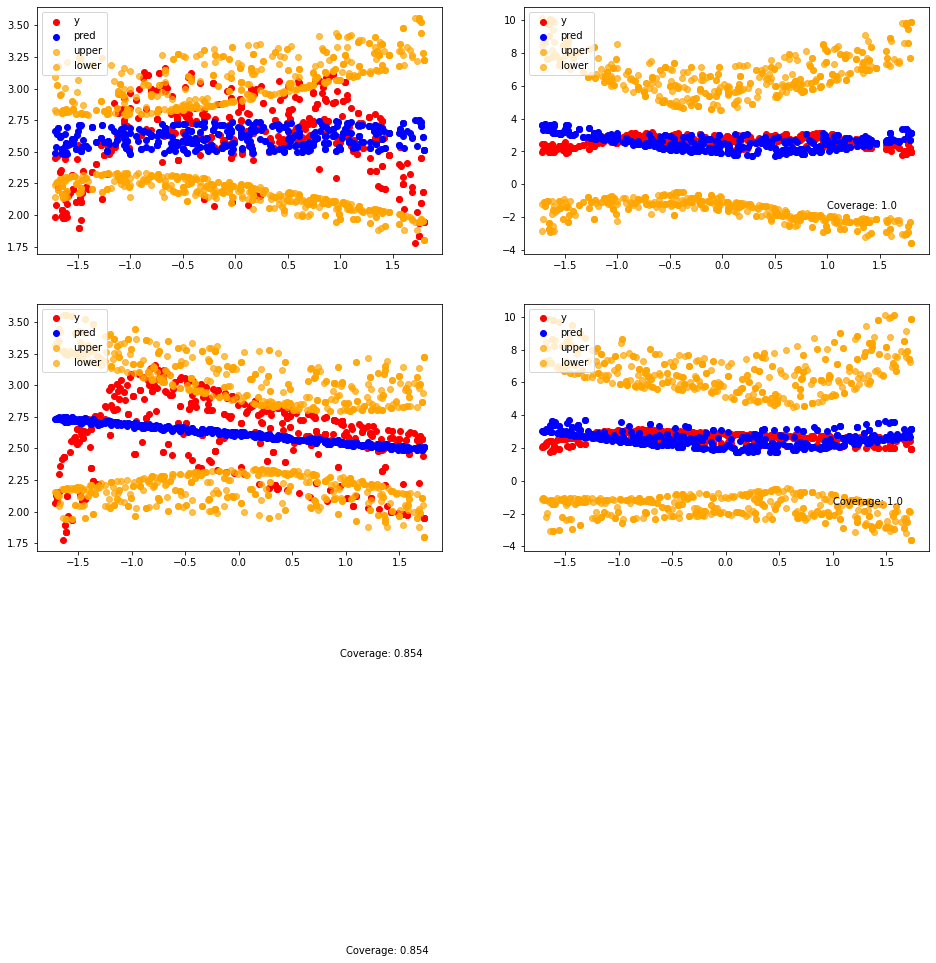

In [44]:
thin = np.random.randint(0, X.shape[0], size = 500)


fig = plt.figure()
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
_ = plot_uncertainties(results[3][thin,:], Y[thin], X[:,1][thin])
plt.subplot(2, 2, 2)
_ = plot_uncertainties(results_dnn[3][thin,:], Y[thin,:], X[:,1][thin])

plt.subplot(2, 2, 3)
#plt.xlim(0, 10)
#plt.ylim(-4, 4)
_ = plot_uncertainties(results[3][thin,:], Y[thin,:], X[:,0][thin])

plt.subplot(2, 2, 4)
#plt.xlim(0, 10)
#plt.ylim(-4, 4)
_ = plot_uncertainties(results_dnn[3][thin,:], Y[thin,:], X[:,0][thin])

Let's take a look at the posterior distribution of our weights for the linear BNN:

In [14]:
posterior = results[0].layers[0]._posterior(np.array([[0]]))
prior = results[0].layers[0]._prior(np.array([[0]]))

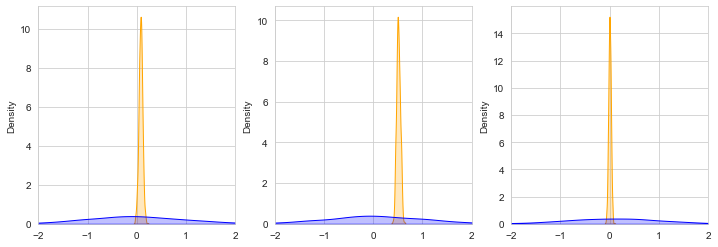

In [15]:
warnings.filterwarnings('ignore')
samples = posterior.sample(1000).numpy()
prior_samples = prior.sample(1000).numpy()
sn.set_style('whitegrid')
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xlim(-2, 2)
    sn.distplot(samples[:,i], color="orange", hist=False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1})
    sn.distplot(prior_samples[:,i], color="blue", hist=False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1})

#sn.displot(pd.DataFrame({"x": samples[:,0], "y": samples[:,1]}),x="x",y="y", kind="kde")


BNN weights:

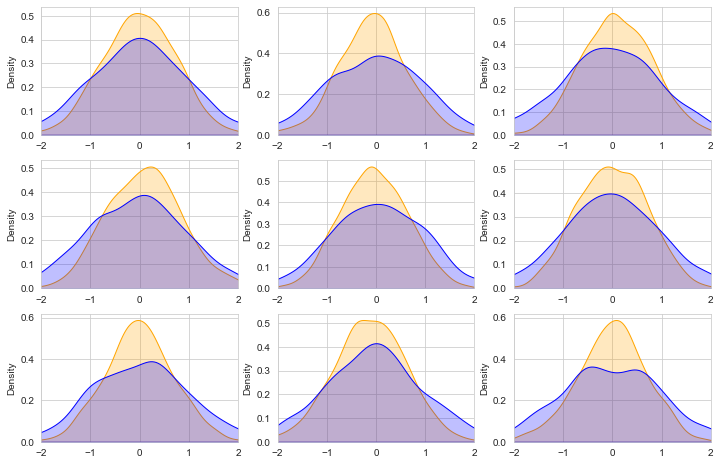

In [143]:
posterior = results_dnn[0].layers[0]._posterior(np.array([[0]]))
prior = results_dnn[0].layers[0]._prior(np.array([[0]]))
samples = posterior.sample(1000).numpy()
prior_samples = prior.sample(1000).numpy()
sn.set_style('whitegrid')
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xlim(-2, 2)
    sn.distplot(samples[:,i], color="orange", hist=False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1})
    sn.distplot(prior_samples[:,i], color="blue", hist=False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1})